In [1]:
import numpy as np
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from gc import collect
from torch.cuda import empty_cache
import json
import time
from langgraph.graph import END,StateGraph,START
from pprint import pprint
import ast
import chromadb
import gc
from chromadb.config import Settings
from pprint import pprint

In [2]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


In [3]:
vectorstore_directory="/Users/imayu/Desktop/Coding Projects/equity research report multi agent langgraph/ICICI_vectorstore_3500_350"
CHROMA_COLLECTION="ICICI_vectorstore_3500_350"
client=chromadb.Client(Settings(is_persistent=True,persist_directory=vectorstore_directory))
collection=client.get_collection(name=CHROMA_COLLECTION)
all_items=collection.get(include=["metadatas","documents"])

In [4]:
len(all_items['metadatas'])

15

# Helper Functions

In [5]:
def preprocess_company_name(company_name):
    return company_name.replace("Bank Ltd","").replace("Inc","").replace("Ltd","").replace("Co Ltd","").replace("LLC","").replace("AB","").strip()

In [6]:
def release_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [7]:
def retrieve(all_items,company_name):
    rel_documents=[]
    documents=all_items['documents']
    docs_1=[d for d in documents if company_name.lower() in d.lower()]
    docs_2=[d for d in documents if company_name in d]
    docs=list(set(docs_1)|(set(docs_2)))
    return docs

In [8]:
def company_name_acronym(company_name):
    acronym=[name_subset[0] for name_subset in company_name.split() if (not(name_subset in ['of','y','de']))]
    acronym="".join(acronym)
    return acronym

In [9]:
company_name_acronym("State Bank of India")

'SBI'

In [10]:
def retrieve_combo(all_items,company_name,add_acronym=True):
    query_str=""
    name_list=[]
    chunk_list=[]
    name_variations=[]
    company_=preprocess_company_name(company_name)
    for name_subset in company_.split():
        query_str=(query_str+ " "+name_subset).strip()
        name_variations.append(query_str)
        chunks=retrieve(all_items,query_str)
        for chunk in chunks:
            if chunk not in chunk_list:
                chunk_list.append(chunk)
    if (len(company_.split()) >2) and add_acronym:
        company_acronym=company_name_acronym(company_)
        name_variations.append(company_acronym)
        relevant_chunk_text=retrieve(all_items,company_acronym)
        if len(relevant_chunk_text)>0:
            chunk_list=chunk_list+relevant_chunk_text
    final_chunks=(list(set(chunk_list)))
    return final_chunks,name_variations

In [11]:
retrieve_combo(all_items,"Star Cement")[1]

['Star', 'Star Cement']

In [12]:
def post_process(generation):
    try:
        res=[]
        sentences = generation.split("*")
        for sentence in sentences:
            sentence=sentence.replace("*","")
            sentence=sentence.replace("\n","")
            if sentence.strip() not in res:
                s=sentence.split(" ")
                if len(s) > 3:
                    res.append(sentence.strip())
        if "" in res:
            res.remove("")
        return res
    except Exception as e:
        print(f"Error observed in Post Processing of LLM sentences Extraction: {e}")

# Loading The LLM

In [13]:
#LM studio requires v1 as prefix
BASE_URL = "http://127.0.0.1:1234/v1"

llm = ChatOpenAI(
    model="gemma-2-9b",       # or whichever model you started
    api_key="lm-studio",     # dummy key
    base_url=BASE_URL,
    temperature=0,
    max_tokens=1000
)


# Prompts

In [14]:
extraction_prompt_template = """
You are given two inputs:
1. A research report context: {context}
2. A flagged company name: {company_name}

Your task:
- Extract all sentences from the research report that mention the flagged company.
- These sentences may include details such as:
  - Financial performance of the company
  - Analyst recommendations (e.g., Buy/Hold/Sell, MW/OW/UW)
  - Analyst Opinions about the company
  - Ignore any information that appears inside tables, tabular data, or lists of numbers.
  - Only consider full sentences written in prose (narrative text).

If no sentences in the context mention the flagged company, return exactly:
"The document does not contain anything about flagged company"

Output Instructions:
- Provide your answer where each sentence is placed in a list item. 
- Each sentence must start with a bullet point('*') and end with a period('.').
- Each list item must be different from the others and Each list item must contaim one sentence only, formatted like this:
    * Sentence 1
    * Sentence 2
    * Sentence 3
- Do not add any prefix or suffix such as "extracted sentences","answer" etc. Just provide the list with bullet points.
"""

In [15]:
sentiment_prompt_template="""You are a text classification assistant. 
Classify the given sentence into one of three categories:
- Promotional (positive, advertising, marketing, or endorsement tone)
- Critical (negative, complaint, or disapproving tone)
- Neutral (objective, factual, or balanced tone)

Sentence: {sentence}

Answer with only one word: Promotional, Critical, or Neutral.
Do not add any prefix or suffix to your answer. Do not add special character(such as "\n") in the beginning or end of your answer """

In [16]:
fl_prompt_template="""
You are a text classification assistant.

Classify the following sentence into one of two categories:
- Forward Looking: contains speculation, prediction, expectation, or evaluation of future performance/potential.
- Not Forward Looking: factual, descriptive, or retrospective with no future-oriented speculation.

Sentence: {sentence}

Answer with only one label: Forward Looking or Not Forward Looking.
Do not add any prefix or suffix to your answer. Do not add special character(such as "\n") in the beginning or end of your answer 
"""

# Agents

In [116]:
from typing import TypedDict, List
class agent_input(TypedDict):
    company_name:str
    report_vector_data:dict
    agents_to_call:List[str]
    company_name_variations:List[str]
    documents:List[str]
    extraction:List[str]
    sentiments:dict
    sentiment_flagged_sentences:List[str]
    forward_looking_classifications:dict
    forward_looking_flagged_sentence:List[str]
    aggregated_output:dict

In [117]:
def retrieval_agent(state):
    print("Running Retrieval Agent")
    company_name=state['company_name']
    vectorstore_data=state['report_vector_data']
    print(state['agents_to_call'])
    docs,company_name_variations=retrieve_combo(vectorstore_data,company_name)
    state['documents']=docs
    state['company_name_variations']=company_name_variations
    return state

In [118]:
def sentence_extraction_agent(state):
    print("Running Sentence Extraction Agent")
    company_name=preprocess_company_name(state['company_name'])
    docs=state['documents']
    extraction_prompt=PromptTemplate(input_variables=['context','company_name'],template=extraction_prompt_template)
    extraction_chain=extraction_prompt|llm|StrOutputParser()
    extraction=[]
    for i in range(len(docs)):
        generation=extraction_chain.invoke({'context':docs[i],"company_name":company_name})
        release_memory()
        sentences=post_process(generation)
        for sentence in sentences:
            if sentence not in extraction:
                extraction.append(sentence)
    state['extraction']=extraction
    return state

In [119]:
def sentiment_detection_agent(state):
    print("Running Sentiment Detection Agent")
    extraction=state['extraction']
    sentiment_prompt=PromptTemplate(input_variables=['sentence'],template=sentiment_prompt_template)
    sentiment_chain=sentiment_prompt|llm|StrOutputParser()
    sentiments={}
    flagged_sents=[]
    for sent in extraction:
        val=sentiment_chain.invoke({"sentence":sent})
        release_memory()
        val=val.strip()
        sentiments[sent]=val
        if "Neutral" not in val:
            flagged_sents.append(sent)
    state['sentiments']=sentiments
    state['sentiment_flagged_sentences']=flagged_sents
    return {"sentiments":sentiments,"sentiment_flagged_sentences":flagged_sents}

In [120]:
def forward_looking_agent(state):
    print("Running Forward Looking Agent")
    extraction=state['extraction']
    fl_prompt=PromptTemplate(input_variables=['sentence'],template=fl_prompt_template)
    fl_chain=fl_prompt|llm|StrOutputParser()
    fl_dict={}
    flagged_sents=[]
    for sent in extraction:
        val=fl_chain.invoke({"sentence":sent})
        release_memory()
        val=val.strip()
        fl_dict[sent]=val
        if "Not Forward Looking" not in val:
            flagged_sents.append(sent)
    state['forward_looking_classifications']=fl_dict
    state['forward_looking_flagged_sentence']=flagged_sents
    return {"forward_looking_classifications":fl_dict,"forward_looking_flagged_sentence":flagged_sents}
    # return state

In [121]:
def sentiment_agent_condition_check(state):
    agent_identification_str='sentiment_detection_agent'
    if agent_identification_str in state['agents_to_call']:
        return "sentiment_detection_agent"
    else:
        return "aggregation_agent"
        

In [122]:
def forward_looking_agent_condition_check(state):
    agent_identification_str='forward_looking_agent'
    if agent_identification_str in state['agents_to_call']:
        return "forward_looking_agent"
    else:
        return "aggregation_agent"
         

In [129]:
def aggregation_agent(state):
    dict_keys=["sentiments","forward_looking_classifications"]
    state_keys=list(state.keys())
    for key in dict_keys:
        if key not in state_keys:
            state[key]={}
    list_keys=['sentiment_flagged_sentences','forward_looking_flagged_sentence']
    for key in list_keys:
        if key not in state_keys:
            state[key]=[]
    aggregated_output={}
    aggregated_output['Provided Company Name']=state['company_name']
    aggregated_output['Company Name Variations']=state['company_name_variations']
    aggregated_output['agents_to_call']=state['agents_to_call']
    aggregated_output['Total Number of Sentences about the provided company']=len(state['extraction'])
    aggregated_output['Total Number of Promotional/Critical Sentences']=len(state['sentiment_flagged_sentences'])
    aggregated_output['Total Number of Forward Looking Sentences']=len(state['forward_looking_flagged_sentence'])
    state['aggregated_output']=aggregated_output
    return state

In [130]:
workflow=StateGraph(agent_input)
#Nodes
workflow.add_node("retrieval_agent",retrieval_agent)
workflow.add_node("sentence_extraction_agent",sentence_extraction_agent)
workflow.add_node("sentiment_detection_agent",sentiment_detection_agent)
workflow.add_node("forward_looking_agent",forward_looking_agent)
workflow.add_node("aggregation_agent",aggregation_agent)
#Edges
workflow.add_edge(START,"retrieval_agent")
workflow.add_edge("retrieval_agent","sentence_extraction_agent")
workflow.add_conditional_edges("sentence_extraction_agent",sentiment_agent_condition_check,
                              {"sentiment_detection_agent":"sentiment_detection_agent","aggregation_agent":"aggregation_agent"})
workflow.add_conditional_edges("sentence_extraction_agent",forward_looking_agent_condition_check,
                              {"forward_looking_agent":"forward_looking_agent","aggregation_agent":"aggregation_agent"})
workflow.add_edge("forward_looking_agent","aggregation_agent")
workflow.add_edge("sentiment_detection_agent","aggregation_agent")

graph=workflow.compile()

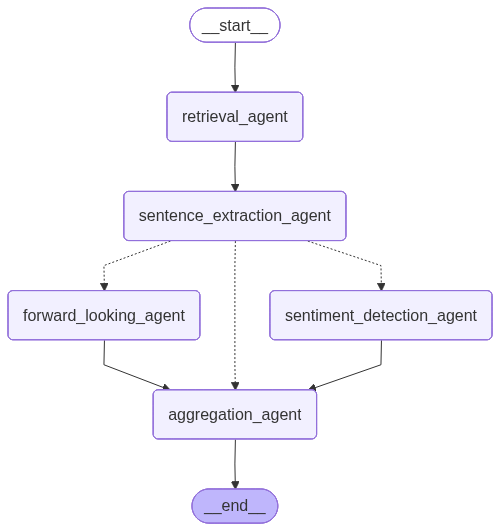

In [131]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [136]:
import time
start_time=time.time()
agents_to_call=["sentiment_detection_agent","forward_looking_agent"]
inputs={"report_vector_data":all_items,"company_name":"Star Cement","agents_to_call":agents_to_call}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint(f"Node {key} :")
    pprint("\n---\n")

print(time.time()-start_time)

Running Retrieval Agent
['sentiment_detection_agent', 'forward_looking_agent']
'Node retrieval_agent :'
'\n---\n'
Running Sentence Extraction Agent
'Node sentence_extraction_agent :'
'\n---\n'
Running Forward Looking Agent
Running Sentiment Detection Agent
'Node forward_looking_agent :'
'\n---\n'
'Node sentiment_detection_agent :'
'\n---\n'
'Node aggregation_agent :'
'\n---\n'
380.8375310897827


In [137]:
value.keys()

dict_keys(['company_name', 'report_vector_data', 'agents_to_call', 'company_name_variations', 'documents', 'extraction', 'sentiments', 'sentiment_flagged_sentences', 'forward_looking_classifications', 'forward_looking_flagged_sentence', 'aggregated_output'])

In [139]:
value['aggregated_output']

{'Provided Company Name': 'Star Cement',
 'Company Name Variations': ['Star', 'Star Cement'],
 'agents_to_call': ['sentiment_detection_agent', 'forward_looking_agent'],
 'Total Number of Sentences about the provided company': 60,
 'Total Number of Promotional/Critical Sentences': 3,
 'Total Number of Forward Looking Sentences': 28}